In [ ]:
import pytesseract
pytesseract.pytesseract.tesseract_cmd = r'C:\Program Files\Tesseract-OCR\tesseract.exe'  # 👈 Update if installed elsewhere

from PIL import Image
import pandas as pd
import os
import re


In [23]:
def extract_text_from_image(image_path):
    image = Image.open(image_path)
    text = pytesseract.image_to_string(image, config='--psm 6')  # Page segmentation mode 6 works well for tables
    return text


In [24]:
def parse_rate_table(text, site, mode):
    lines = text.strip().split("\n")
    data = []
    
    for line in lines:
        if re.match(r'^\d{2,3}', line.strip()):  # line starts with discount like 50, 55, etc.
            parts = re.split(r'\s+', line.strip())
            discount = parts[0]
            for i, rate in enumerate(parts[1:], start=1):
                data.append({
                    'site': site,
                    'mode': mode,
                    'discount': int(discount),
                    'class': f'class_{i}',  # can replace later with L5C, 5C, etc.
                    'rate': rate
                })
    return pd.DataFrame(data)


In [25]:
def process_images_in_folder(folder_path):
    all_data = []
    for filename in os.listdir(folder_path):
        if filename.lower().endswith((".png", ".jpg", ".jpeg")):
            site_mode = filename.replace(".png", "").replace(".jpg", "").replace(".jpeg", "")
            try:
                site, mode = site_mode.split("_")
                text = extract_text_from_image(os.path.join(folder_path, filename))
                df = parse_rate_table(text, site=site, mode=mode.upper())
                all_data.append(df)
            except Exception as e:
                print(f"❌ Skipped {filename}: {e}")
    return pd.concat(all_data, ignore_index=True)


In [29]:
print(extract_text_from_image("rates/louisville_sqyd.png"))


Xpress Global Systems, Inc.
Origin 30720 GA
Destination 40228 KY Destination Zone = 04 38
j usc | sc | 1M | 2M | 3M | @ Sq¥d © CWT

[ Discount | 70.07% | 70.07% | 70.07% | 70.07% | 70.07%

[Comet | 0.3968 | 03844 [0.3761

| Carpet Tile | 0.6745 | 0.6535 | 0.6394 | 0.6254 | 0.6113 © Rates C Atemation
@ Discounted C Base



In [27]:
image_folder_path = "rates"  # 🔁 replace with your folder
combined_df = process_images_in_folder(image_folder_path)


In [28]:
combined_df

""


In [31]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

def crop_table_rows(image_path, display=False):
    """
    Crops the Discount, Carpet, and Carpet Tile rows from a structured rate table.
    Assumes consistent layout as per provided samples.
    
    Parameters:
        image_path (str): Path to the rate table image.
        display (bool): Whether to visually display cropped rows.

    Returns:
        Tuple: (discount_row_img, carpet_row_img, carpet_tile_row_img)
    """

    # Load image in grayscale
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    h = img.shape[0]

    # Approximate crop zones based on consistent image layout
    discount_row = img[int(h * 0.27):int(h * 0.36), :]
    carpet_row = img[int(h * 0.36):int(h * 0.45), :]
    tile_row = img[int(h * 0.45):int(h * 0.54), :]

    if display:
        titles = ['Discount', 'Carpet', 'Carpet Tile']
        crops = [discount_row, carpet_row, tile_row]
        for i, crop in enumerate(crops):
            plt.figure(figsize=(10, 2))
            plt.imshow(crop, cmap='gray')
            plt.title(titles[i])
            plt.axis('off')
            plt.show()

    return discount_row, carpet_row, tile_row


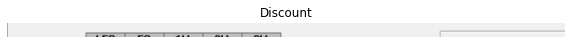

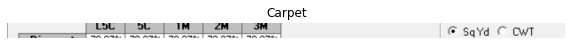

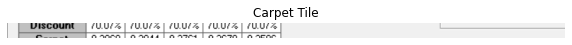

In [32]:
discount, carpet, tile = crop_table_rows("rates/louisville_sqyd.png", display=True)
